In [1]:
import os
import cv2
import tqdm
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
# Global image directory path
IMG_DIR = "/Users/susanketsarkar/Desktop/Code/Meesho/data/train_images"  # Update with your image directory


class CenterCropWithMargin:
    def __init__(self, margin_percent=0.1):
        self.margin_percent = margin_percent
    
    def __call__(self, img):
        # Calculate the cropping dimensions
        width, height = img.size
        crop_margin_w = int(width * self.margin_percent)
        crop_margin_h = int(height * self.margin_percent)
        
        # Crop the image by removing the calculated margin from each side
        cropped_img = img.crop((
            crop_margin_w, crop_margin_h,
            width - crop_margin_w, height - crop_margin_h
        ))
        return cropped_img
    
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, label=False):
        self.dataframe = dataframe
        self.transform = transform
        self.label = label

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)

        if self.label:
            label = self.dataframe.iloc[idx]['label']
            return image, label
        return image

def load_data(csv_path, attr_to_predict, nan_attributes=[]):
    # Load data
    df = pd.read_csv(csv_path)
    
    # Extract relevant columns
    df = df[['id', 'Category', attr_to_predict]]
    
    # Store the original length of the DataFrame
    l1 = len(df)

    # Create a mask for NaN values and specified attributes to be treated as NaN
    mask_nan = df[attr_to_predict].isna() | df[attr_to_predict].isin(nan_attributes)
    
    # Create a DataFrame for rows with NaN or specified attributes in the target attribute
    df_nan = df[mask_nan]
    
    # Drop rows with missing values in the target attribute
    df_no_nan = df[~mask_nan]
    
    # Print the number of NaN objects
    print("Number of NaN objects: ", l1 - len(df_no_nan))
    
    # Create image paths for non-NaN DataFrame
    df_no_nan['image_path'] = df_no_nan['id'].apply(lambda x: os.path.join(IMG_DIR, f"{str(x).zfill(6)}.jpg"))
    
    # Create image paths for NaN DataFrame (optional)
    df_nan['image_path'] = df_nan['id'].apply(lambda x: os.path.join(IMG_DIR, f"{str(x).zfill(6)}.jpg"))
    
    return df_no_nan, df_nan


def preprocess_data(df, attr_to_predict):
    # Encode labels
    le = LabelEncoder()
    df['label'] = le.fit_transform(df[attr_to_predict])
    
    return df, le

def plot_collage(images, labels, ncols=3):
    """Plots a collage of images with their corresponding labels."""
    n_images = len(images)
    n_rows = (n_images + ncols - 1) // ncols  # Calculate the number of rows needed

    plt.figure(figsize=(15, 5 * n_rows))
    for idx, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(n_rows, ncols, idx + 1)
        plt.imshow(img.permute(1, 2, 0))  # Change from C x H x W to H x W x C
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def build_cnn_model(num_classes):
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Flatten(),
        nn.Linear(64 * 16 * 16, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes)
    )
    return model

def plot_loss(losses):
    """Plots training and validation loss and accuracy over epochs."""
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Loss
    plt.plot(epochs, losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def train_cnn_on_attribute(csv_path, attr_to_predict, output_csv, epochs=10, batch_size=4):
    # Load and prepare data
    df, nan_df = load_data(csv_path, attr_to_predict, nan_attributes = [])
    df, le = preprocess_data(df, attr_to_predict)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        # CenterCropWithMargin(margin_percent=0.1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    
    dataset = CustomImageDataset(dataframe=df, transform=transform, label=True)
    nan_dataset = CustomImageDataset(dataframe=nan_df, transform=transform)
    
    # Split the dataset
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    nan_loader = DataLoader(nan_dataset, batch_size=batch_size, shuffle=False)

    # Build CNN model
    print("Building the model...")
    model = build_cnn_model(num_classes=len(le.classes_))
    
    # Move model to GPU if available
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    print(f"Training the model on {train_size} data points...")
    model.train()

    losses=[]
    acc=[]
    for epoch in tqdm.tqdm(range(epochs)):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())

    plot_loss(losses)

    # Evaluate the model
    print("Evaluating the model...")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Print metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=le.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    print(f"Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")

    print("Populating NaN values...")
    all_preds = []
    images_to_plot = []
    
    with torch.no_grad():
        for images in nan_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            images_to_plot.append(images.cpu())  # Store images for plotting

    all_preds = np.concatenate(all_preds)
    images_to_plot = torch.cat(images_to_plot)

    if not os.path.exists(output_csv):
        main_df = pd.read_csv(csv_path)
    else:
        main_df = pd.read_csv(output_csv)
    all_preds=le.inverse_transform(all_preds)
    for i, idx in enumerate(nan_df.id):
        main_df.loc[main_df["id"] == idx, attr_to_predict] = all_preds[i]
    main_df.to_csv(output_csv, index=False)

    # Plotting collage of classified images
    random_indices = np.random.choice(len(images_to_plot), size=9, replace=False)
    selected_images = images_to_plot[random_indices]
    selected_labels = all_preds[random_indices]
    plot_collage(selected_images, selected_labels)

TRAINING ON color
Number of NaN objects:  1257
Building the model...
Training the model on 5409 data points...


100%|██████████| 25/25 [06:32<00:00, 15.71s/it]


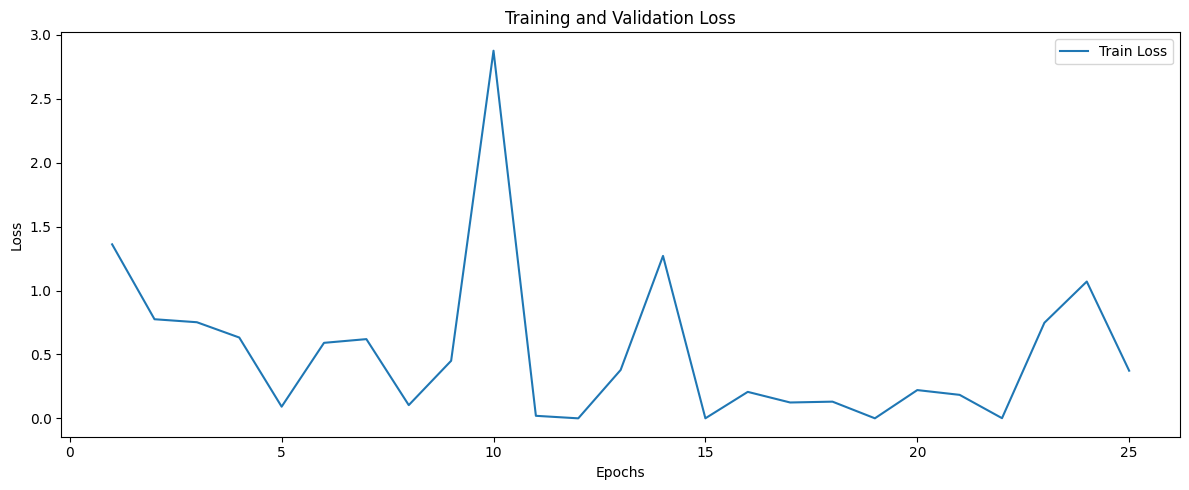

Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

       black       0.74      0.78      0.76        76
     default       0.75      0.76      0.76       208
  multicolor       0.73      0.59      0.65       183
       white       0.75      0.90      0.82       134

    accuracy                           0.74       601
   macro avg       0.74      0.76      0.75       601
weighted avg       0.74      0.74      0.74       601

Confusion Matrix:
[[ 59   7   4   6]
 [  7 159  32  10]
 [ 11  39 108  25]
 [  3   6   4 121]]
Accuracy: 74.38%
Populating NaN values...


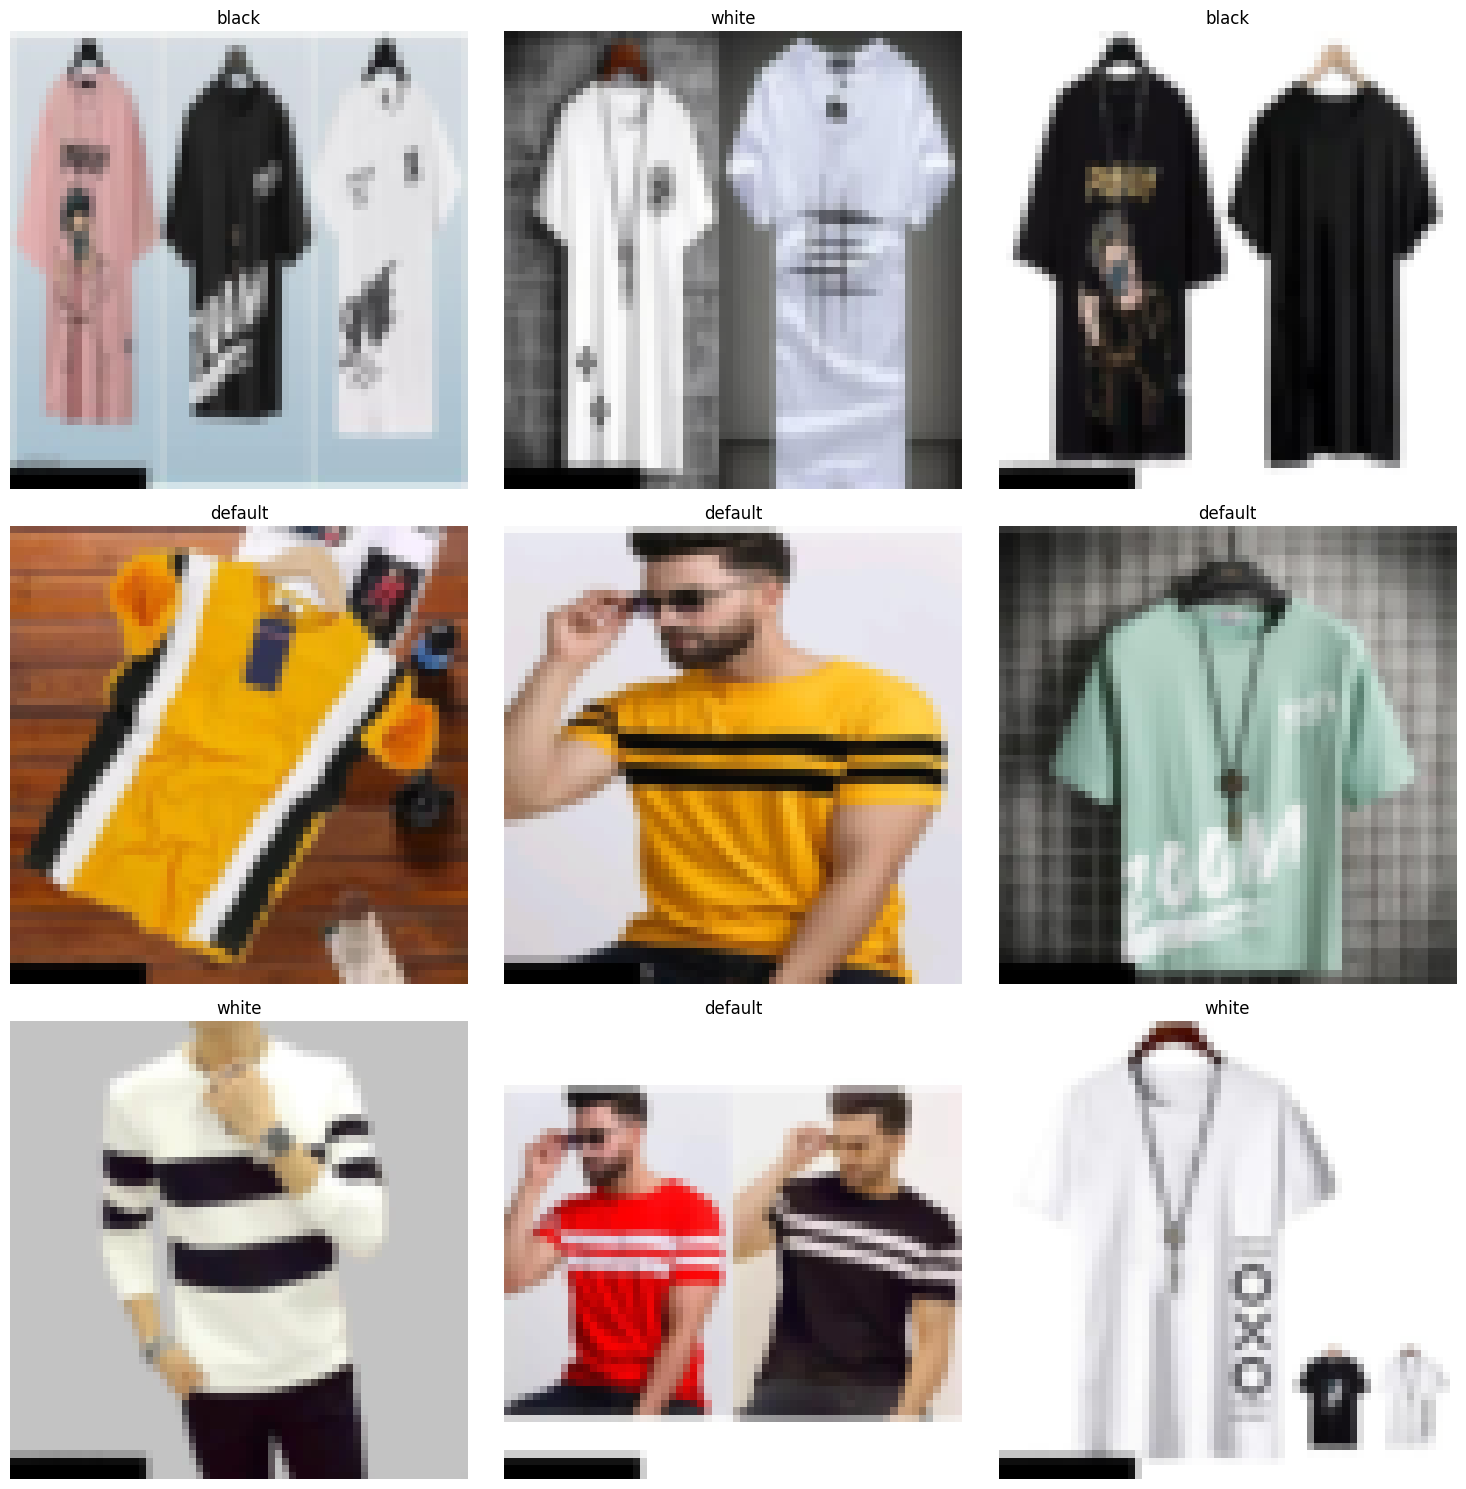

TRAINING ON neck
Number of NaN objects:  1123
Building the model...
Training the model on 5529 data points...


100%|██████████| 25/25 [06:46<00:00, 16.26s/it]


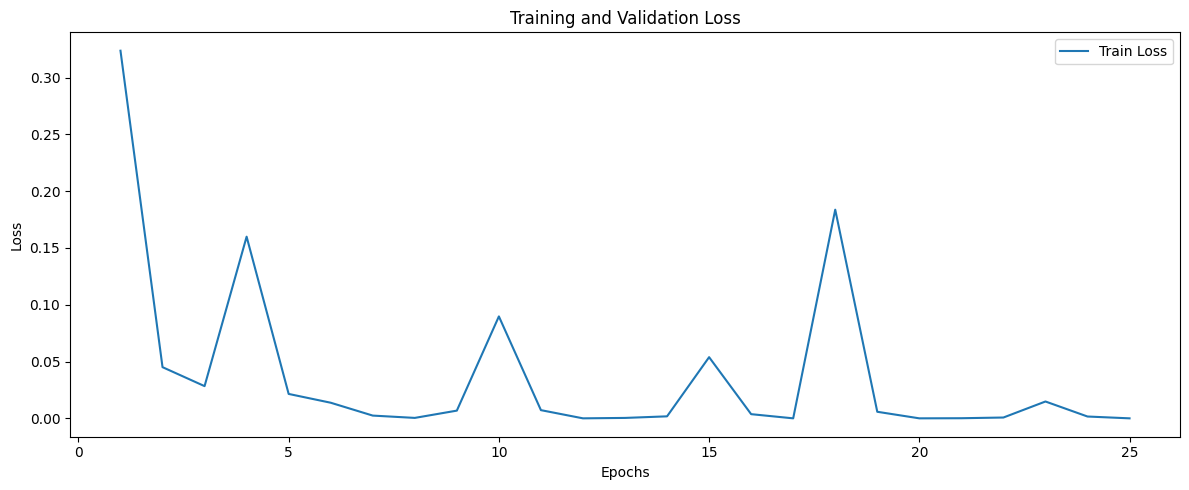

Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

        polo       1.00      0.97      0.98       306
       round       0.97      1.00      0.98       309

    accuracy                           0.98       615
   macro avg       0.98      0.98      0.98       615
weighted avg       0.98      0.98      0.98       615

Confusion Matrix:
[[296  10]
 [  1 308]]
Accuracy: 98.21%
Populating NaN values...


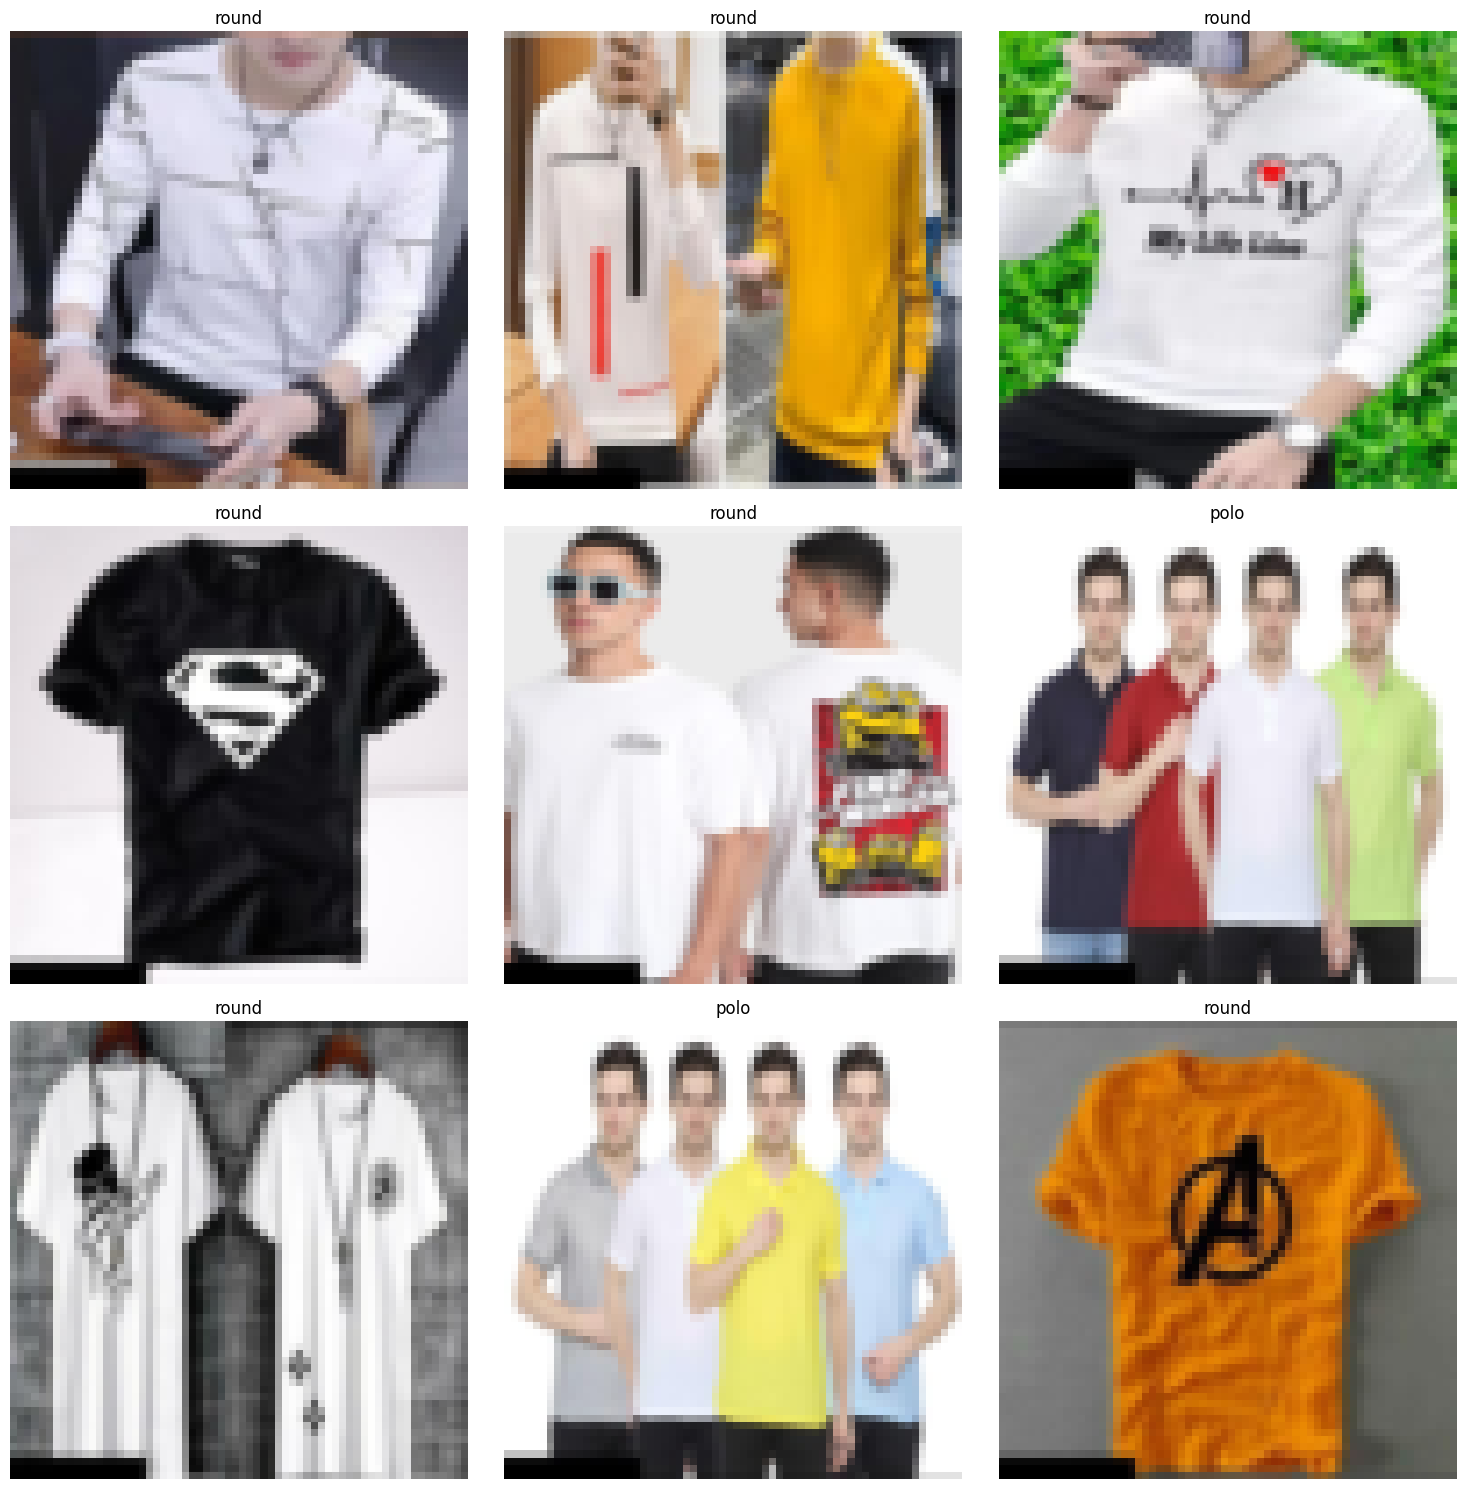

TRAINING ON pattern
Number of NaN objects:  1476
Building the model...
Training the model on 5211 data points...


100%|██████████| 25/25 [06:15<00:00, 15.02s/it]


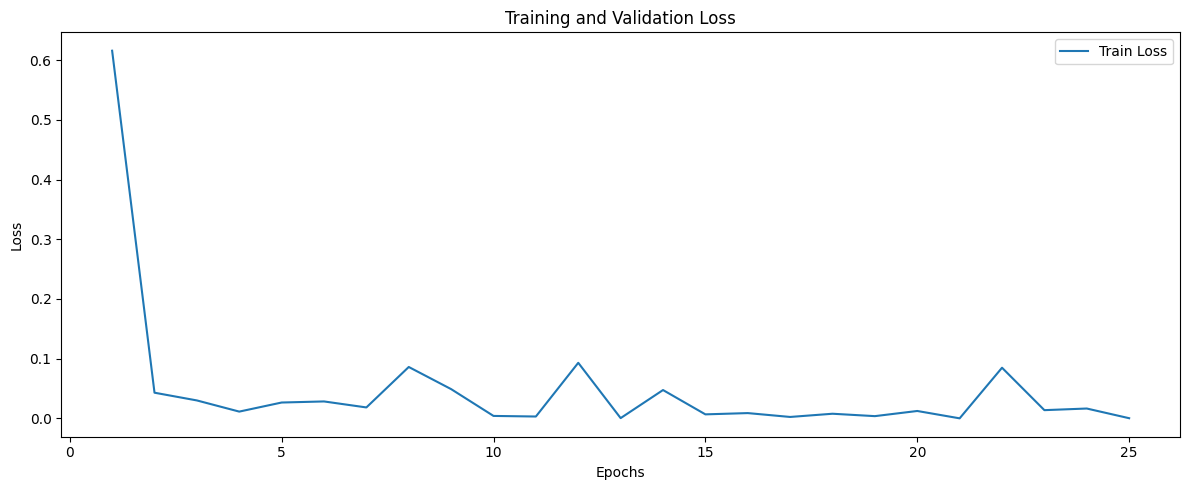

Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

     printed       0.93      0.99      0.96       241
       solid       0.99      0.95      0.97       339

    accuracy                           0.96       580
   macro avg       0.96      0.97      0.96       580
weighted avg       0.97      0.96      0.96       580

Confusion Matrix:
[[238   3]
 [ 18 321]]
Accuracy: 96.38%
Populating NaN values...


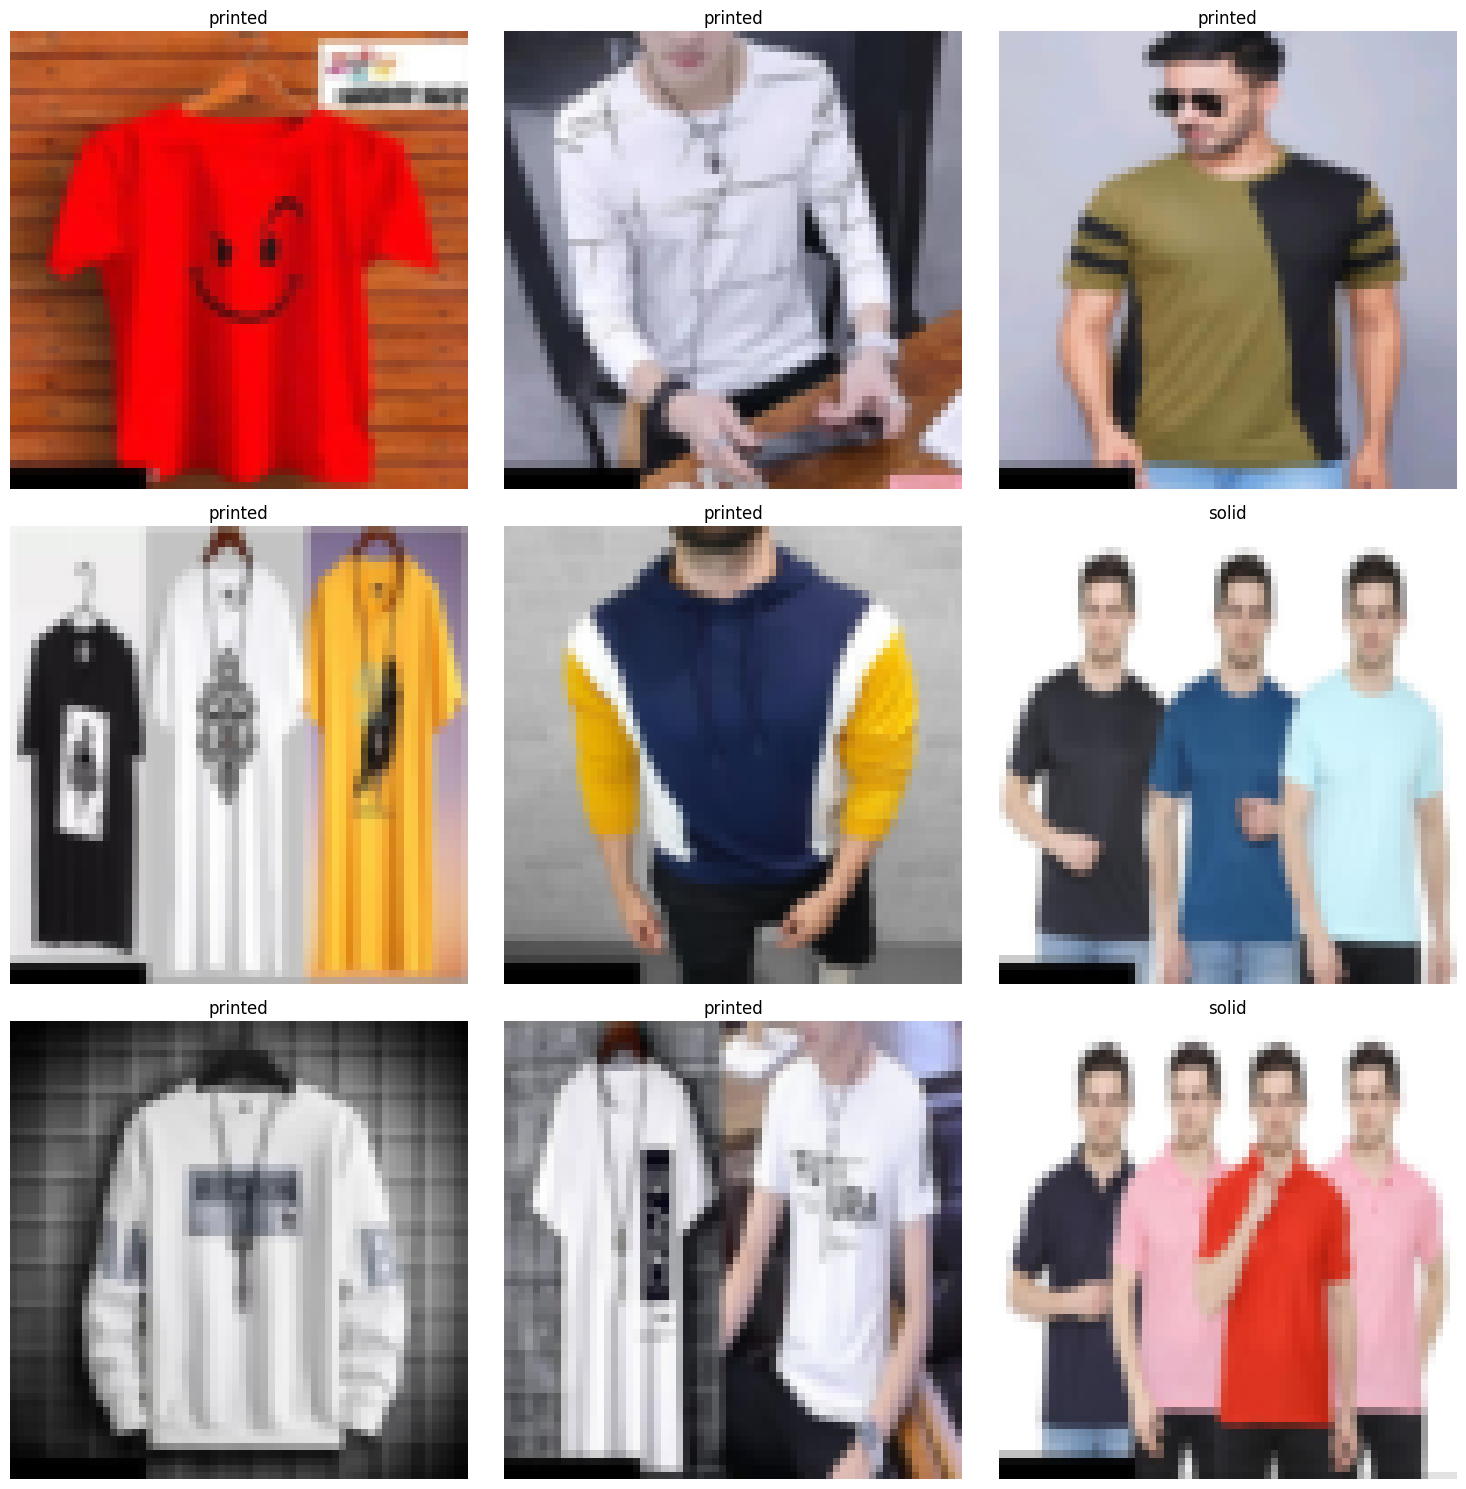

TRAINING ON print_or_pattern_type
Number of NaN objects:  1318
Building the model...
Training the model on 5354 data points...


100%|██████████| 25/25 [07:17<00:00, 17.49s/it]


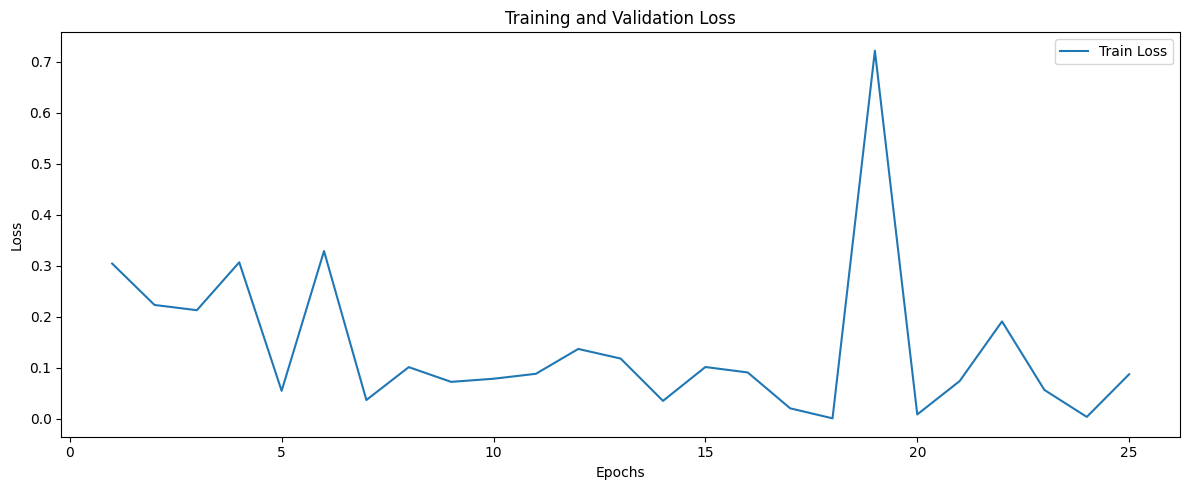

Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

     default       0.80      0.87      0.83       194
       solid       0.98      0.94      0.96       337
  typography       0.63      0.58      0.60        64

    accuracy                           0.88       595
   macro avg       0.80      0.80      0.80       595
weighted avg       0.88      0.88      0.88       595

Confusion Matrix:
[[169   6  19]
 [ 17 317   3]
 [ 26   1  37]]
Accuracy: 87.90%
Populating NaN values...


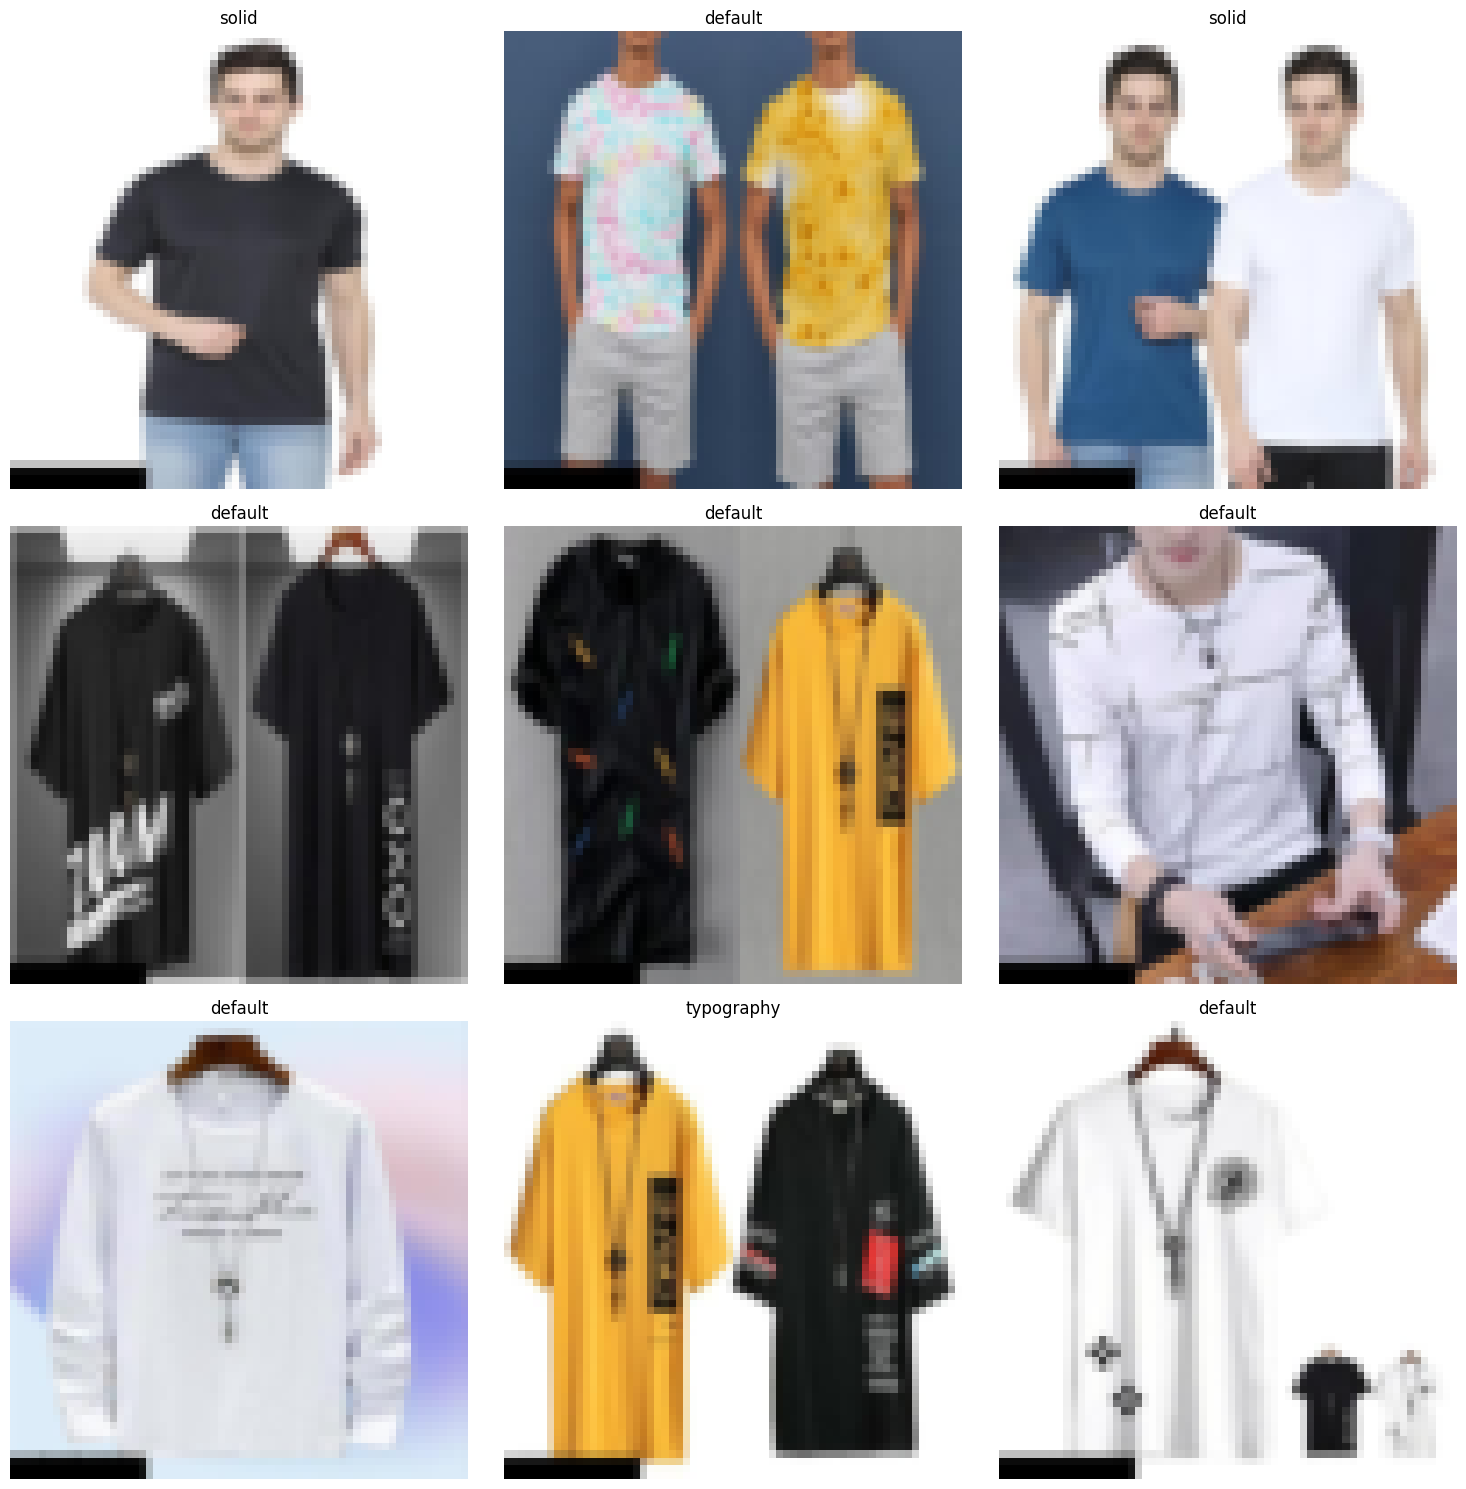

TRAINING ON sleeve_length
Number of NaN objects:  1290
Building the model...
Training the model on 5379 data points...


100%|██████████| 25/25 [07:12<00:00, 17.31s/it]


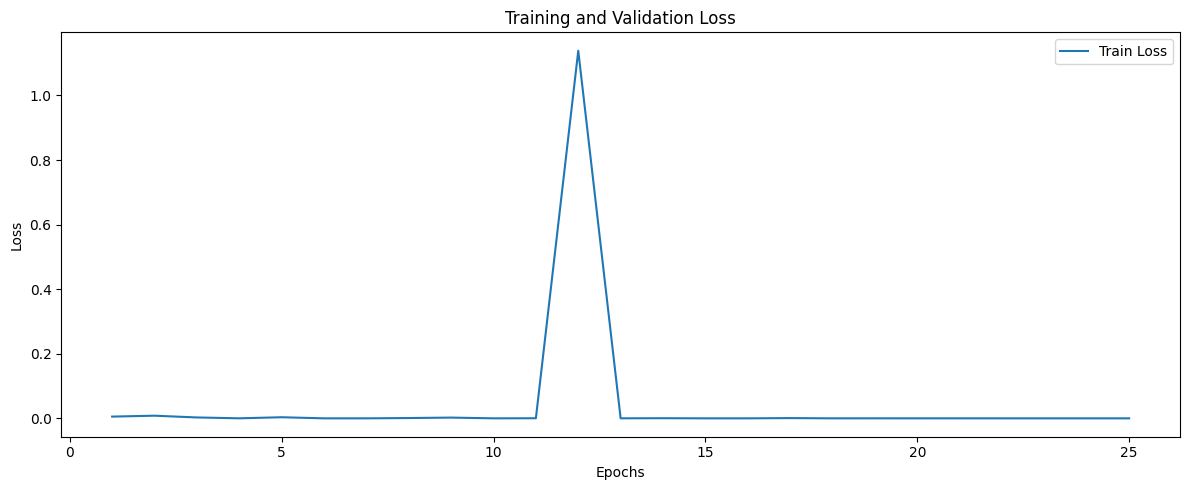

Evaluating the model...
Classification Report:
               precision    recall  f1-score   support

 long sleeves       1.00      0.76      0.87        34
short sleeves       0.99      1.00      0.99       564

     accuracy                           0.99       598
    macro avg       0.99      0.88      0.93       598
 weighted avg       0.99      0.99      0.99       598

Confusion Matrix:
[[ 26   8]
 [  0 564]]
Accuracy: 98.66%
Populating NaN values...


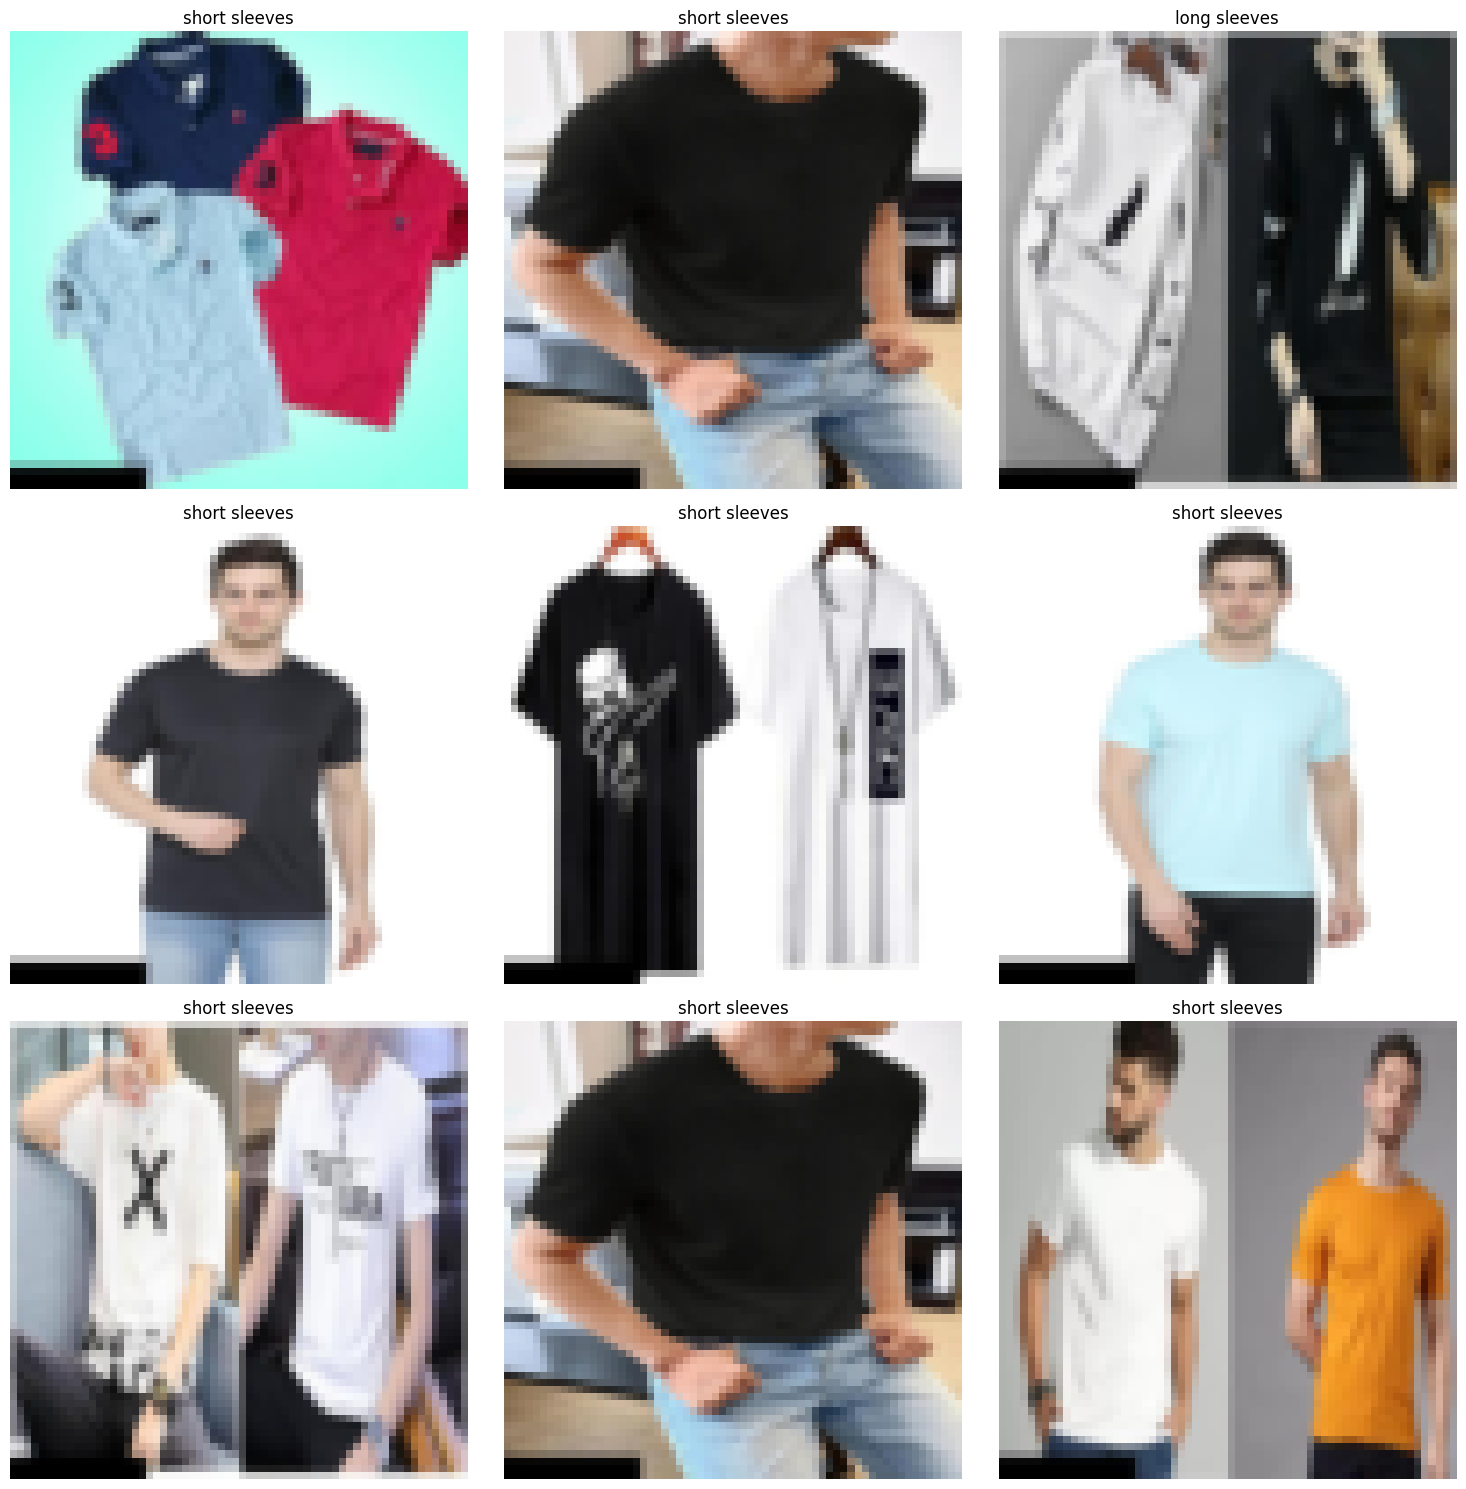

In [6]:
cols = pd.read_csv("../data/cat_wise_csv/Men_Tshirts_data.csv").columns[3:]
for col in cols:
    print(f"TRAINING ON {col}")
    train_cnn_on_attribute("../data/cat_wise_csv/Men_Tshirts_data.csv", col, "../data/filled_data/Men_Tshirts_data.csv", epochs=25, batch_size=32)